In [1]:
import torch
from torch import nn,tensor
import util
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device='cuda:1'
tx=tensor([[[[-1.,1.]]]]).to(device)
ty=tensor([[[[-1.],[1.]]]]).to(device)
ox=tensor([[[[.5,.5]]]]).to(device)
oy=tensor([[[[.5],[.5]]]]).to(device)
def dx(z):
    return nn.functional.conv2d(z,tx)
def dy(z):
    return nn.functional.conv2d(z,ty)
def mr(z):
    return nn.functional.conv2d(z,-tx,padding=(0,1))
def ml(z):
    return nn.functional.conv2d(z,tx,padding=(0,1))
def mu(z):
    return nn.functional.conv2d(z,-ty,padding=(1,0))
def md(z):
    return nn.functional.conv2d(z,ty,padding=(1,0))
def ax(z):
    return nn.functional.conv2d(z,ox,padding=(0,1))
def ay(z):
    return nn.functional.conv2d(z,oy,padding=(1,0))
def r(z):
    return z[:,:,:,:-1]
def l(z):
    return z[:,:,:,1:]
def u(z):
    return z[:,:,:-1,:]
def d(z):
    return z[:,:,1:,:]

<IPython.core.display.Javascript object>


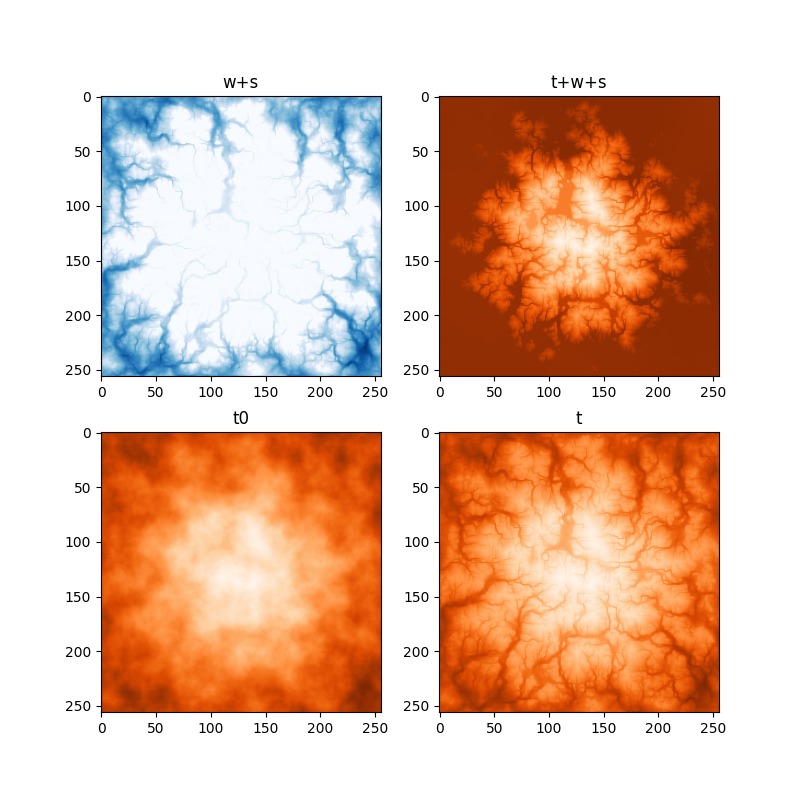

In [3]:
width=height=256
t1=util.perlin_oct((height,width),(8,8),6).unsqueeze(0).unsqueeze(0).to(device)
#t=tensor([[x/128.0+y/128.0 for x in range(width)]for y in range(height)]).unsqueeze(0).unsqueeze(0).to(device)
t=tensor([[1.0001**-((x-128)**2+(y-128)**2) for x in range(width)]for y in range(height)]).unsqueeze(0).unsqueeze(0).to(device)

t+=t1*0.2
t0=t.clone()

w=torch.zeros((height,width)).unsqueeze(0).unsqueeze(0).to(device)
'''
wx=torch.zeros((height,width-1)).unsqueeze(0).unsqueeze(0).to(device)
wy=torch.zeros((height-1,width)).unsqueeze(0).unsqueeze(0).to(device)
'''
wr=torch.zeros((height,width-1)).unsqueeze(0).unsqueeze(0).to(device)
wl=torch.zeros((height,width-1)).unsqueeze(0).unsqueeze(0).to(device)
wu=torch.zeros((height-1,width)).unsqueeze(0).unsqueeze(0).to(device)
wd=torch.zeros((height-1,width)).unsqueeze(0).unsqueeze(0).to(device)

s=torch.zeros((height,width)).unsqueeze(0).unsqueeze(0).to(device)

a=20
drag=0.001
dt=.02
v_fac=(1-drag)**dt
evaporation=0.001
rain=0.0006
rain_period=1
ks=0.02
kd=0.001
%matplotlib notebook
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3= fig.add_subplot(223)
ax4= fig.add_subplot(224)
plt.ion()
fig.show()

fig.canvas.draw()

In [7]:
def im():
    ax1.clear()
    ax1.set_title('w+s')
    im=ax1.imshow((w+s).squeeze(0).squeeze(0).cpu(),cmap='Blues')        
    ax2.clear()
    ax2.set_title('t+w+s')
    ax2.imshow((t+w+s).squeeze(0).squeeze(0).cpu(),cmap='Oranges_r')
    ax3.clear()
    ax3.set_title('t0')
    ax3.imshow(t0.squeeze(0).squeeze(0).cpu(),cmap='Oranges_r')
    ax4.clear()
    ax4.set_title('t')
    ax4.imshow(t.squeeze(0).squeeze(0).cpu(),cmap='Oranges_r')
    fig.canvas.draw()

In [9]:
for i in range(1000):
    w*=(1-evaporation)**dt
    deposit=s*(1-(1-evaporation)**dt)
    s-=deposit
    t+=deposit
    w+=rain*dt*(-np.cos(1+6.28*i*dt/rain_period)*.5+.5)
    
    g=dx(t+w+s)
    wr=(wr-g/(1+g*g)*a*dt)*v_fac
    wr=torch.clamp(torch.min(wr,w[:,:,:,:-1]/dt/4),min=0)
    wl=(wl+g/(1+g*g)*a*dt)*v_fac
    wl=torch.clamp(torch.min(wl,w[:,:,:,1:]/dt/4),min=0)
    
    g=dy(t+w+s)
    wu=(wu-g/(1+g*g)*a*dt)*v_fac
    wu=torch.clamp(torch.min(wu,w[:,:,:-1,:]/dt/4),min=0)
    wd=(wd+g/(1+g*g)*a*dt)*v_fac
    wd=torch.clamp(torch.min(wd,w[:,:,1:,:]/dt/4),min=0)
    dw=(mr(wr)+ml(wl)+mu(wu)+md(wd))*dt
    
    c=s/(w+0.001)
    ds=(mr(wr*r(c))+ml(wl*l(c))+mu(wu*u(c))+md(wd*d(c)))*dt
    
    w+=dw
    s+=ds
    
    erode=(ax(wr**2+wl**2)+ay(wu**2+wd**2))**0.2*ks*dt
    s+=erode
    t-=erode

    deposit=s*(1-(1-kd)**dt)
    s-=deposit
    t+=deposit
    
    
    if i%40==0:
        im()

In [6]:
print("for i in range(1000):\r\n    w*=(1-evaporation)**dt\r\n    deposit=s*(1-(1-evaporation)**dt)\r\n    s-=deposit\n    t+=deposit\n    w+=rain*dt*(-np.cos(1+6.28*i*dt/rain_period)*.5+.5)\r\n    \r\n    g=dx(t+w+s)\r\n    wr=(wr-g/(1+g*g)*a*dt)*v_fac\r\n    wr=torch.clamp(torch.min(wr,w[:,:,:,:-1]/dt/4),min=0)\r\n    wl=(wl+g/(1+g*g)*a*dt)*v_fac\r\n    wl=torch.clamp(torch.min(wl,w[:,:,:,1:]/dt/4),min=0)\r\n    \r\n    g=dy(t+w+s)\r\n    wu=(wu-g/(1+g*g)*a*dt)*v_fac\r\n    wu=torch.clamp(torch.min(wu,w[:,:,:-1,:]/dt/4),min=0)\r\n    wd=(wd+g/(1+g*g)*a*dt)*v_fac\r\n    wd=torch.clamp(torch.min(wd,w[:,:,1:,:]/dt/4),min=0)\r\n    dw=(mr(wr)+ml(wl)+mu(wu)+md(wd))*dt\r\n    \r\n    c=s/(w+0.001)\r\n    ds=(mr(wr*r(c))+ml(wl*l(c))+mu(wu*u(c))+md(wd*d(c)))*dt\r\n    \r\n    w+=dw\r\n    s+=ds\r\n    \r\n    erode=(ax(wr**2+wl**2)+ay(wu**2+wd**2))**0.2*ks*dt\r\n    s+=erode\r\n    t-=erode\r\n\r\n    deposit=s*(1-(1-kd)**dt)\r\n    s-=deposit\n    t+=deposit\n    \r\n    \r\n    if i%40==0:\n        im()")

for i in range(1000):
    w*=(1-evaporation)**dt
    deposit=s*(1-(1-evaporation)**dt)
    s-=deposit
    t+=deposit
    w+=rain*dt*(-np.cos(1+6.28*i*dt/rain_period)*.5+.5)
    
    g=dx(t+w+s)
    wr=(wr-g/(1+g*g)*a*dt)*v_fac
    wr=torch.clamp(torch.min(wr,w[:,:,:,:-1]/dt/4),min=0)
    wl=(wl+g/(1+g*g)*a*dt)*v_fac
    wl=torch.clamp(torch.min(wl,w[:,:,:,1:]/dt/4),min=0)
    
    g=dy(t+w+s)
    wu=(wu-g/(1+g*g)*a*dt)*v_fac
    wu=torch.clamp(torch.min(wu,w[:,:,:-1,:]/dt/4),min=0)
    wd=(wd+g/(1+g*g)*a*dt)*v_fac
    wd=torch.clamp(torch.min(wd,w[:,:,1:,:]/dt/4),min=0)
    dw=(mr(wr)+ml(wl)+mu(wu)+md(wd))*dt
    
    c=s/(w+0.001)
    ds=(mr(wr*r(c))+ml(wl*l(c))+mu(wu*u(c))+md(wd*d(c)))*dt
    
    w+=dw
    s+=ds
    
    erode=(ax(wr**2+wl**2)+ay(wu**2+wd**2))**0.2*ks*dt
    s+=erode
    t-=erode

    deposit=s*(1-(1-kd)**dt)
    s-=deposit
    t+=deposit
    
    
    if i%40==0:
        im()


In [25]:
rain_period

10